# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score, reciprocal_rank
import numpy as np
from lightfm.cross_validation import random_train_test_split
import os
from scipy.sparse import csr_matrix, vstack
from sklearn.preprocessing import MinMaxScaler

# Data Prep

## Load Data

In [2]:
data = pd.read_csv("./fnb_datav2.csv")

# Remove 
data = data.drop(columns = ["item_descrip", "page"])
data.head(20)
print((data["beh_segment"] == "B43").any())
# TEST:
# Drop rows where "item" column contains "NONE"
# data = data[data["active_ind"] != "Cold Start"]
data = data[data["item"] != "NONE"]
print((data["beh_segment"] == "B43").any())
data.head(20)
# data.shape


True
False


,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind
4,4521,CLICK,05FEB2023,IBAB,Afternoon,INSURE,segment1,B07,Semi Active
5,4521,CHECKOUT,05FEB2023,IBAB,Afternoon,INSURE,segment1,B07,Semi Active
16,14454,CLICK,08FEB2023,CAFM,Morning,TRANSACT,segment2,B01,Active
17,14454,CHECKOUT,08FEB2023,CAFM,Morning,TRANSACT,segment2,B01,Active
18,15000,CLICK,31JAN2023,CARF,Morning,LEND,segment3,B01,Cold Start
19,15000,CHECKOUT,31JAN2023,CARF,Morning,LEND,segment3,B01,Cold Start
26,22924,CLICK,26FEB2023,FIWL,Morning,INVEST,segment2,B01,Active
27,22924,CHECKOUT,26FEB2023,FIWL,Morning,INVEST,segment2,B01,Active
37,23484,CHECKOUT,22FEB2023,CUSS,Afternoon,INVEST,segment2,B01,Cold Start
38,23484,CLICK,22FEB2023,CUSS,Afternoon,INVEST,segment2,B01,Cold Start


In [3]:
# # I remve a random Active user to test the cold start approach later:
# # Step 1: Filter users with active_ind equal to 'Active'
# active_users = data[data['active_ind'] == 'Active']

# # Check if there are any active users
# if not active_users.empty:
#     # Step 2: Randomly select one of these users
#     selected_user = active_users.sample(n=1)

#     # Get the user id of the selected user
#     selected_user_id = selected_user['idcol'].values[0]

#     # Step 3: Move all entries of this selected user to a new dataframe
#     selected_user_df = data[data['idcol'] == selected_user_id]

#     # Step 4: Remove this user's entries from the original dataframe
#     data = data[data['idcol'] != selected_user_id]

# selected_user_df.head()

In [4]:
# Checking transactions for a specific ID:
id = 77196041
data[data["idcol"]==id]

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind
155295,77196041,CLICK,27MAR2023,FICQ,Early,INSURE,segment2,B01,Active
155296,77196041,CHECKOUT,27MAR2023,FIWL,Early,INVEST,segment2,B01,Active
155297,77196041,CHECKOUT,27MAR2023,FILS,Early,INSURE,segment2,B01,Active
155298,77196041,CLICK,27MAR2023,FILS,Early,INSURE,segment2,B01,Active
155299,77196041,CLICK,27MAR2023,FIHC,Early,INSURE,segment2,B01,Active
...,...,...,...,...,...,...,...,...,...
155353,77196041,CLICK,27MAR2023,CACU,Evening,TRANSACT,segment2,B01,Active
155354,77196041,CHECKOUT,27MAR2023,CABC,Early,INVEST,segment2,B01,Active
155355,77196041,CLICK,27MAR2023,CABC,Early,INVEST,segment2,B01,Active
155356,77196041,CHECKOUT,27MAR2023,SEVP,Early,TRANSACT,segment2,B01,Active


In [5]:
data.nunique()

idcol          42606
interaction        2
int_date          88
item             103
tod                4
item_type          6
segment            4
beh_segment       48
active_ind         3
dtype: int64

In [6]:
# Add the following user features
"""
- weekly interaction frequency, 
- most frequenctly item interacted with (other than ALL),

"""

# Give scores to the interactions, and then drop the interaction column:L
# interaction_scores = {
#     'CLICK': 1,
#     'CHECKOUT': 2
# }

interaction_scores = {
    'DISPLAY': 0,
    'CLICK': 1,
    'CHECKOUT': 2
}

# Map interaction scores, fill missing values with 0
data['interaction_scores'] = data['interaction'].map(interaction_scores).fillna(0)

# Add ids for each unique item
data['item_id'] = pd.factorize(data['item'])[0]

# data.drop(columns = ["interaction"])
data.head(40)

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id
4,4521,CLICK,05FEB2023,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0
5,4521,CHECKOUT,05FEB2023,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0
16,14454,CLICK,08FEB2023,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1
17,14454,CHECKOUT,08FEB2023,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1
18,15000,CLICK,31JAN2023,CARF,Morning,LEND,segment3,B01,Cold Start,1,2
19,15000,CHECKOUT,31JAN2023,CARF,Morning,LEND,segment3,B01,Cold Start,2,2
26,22924,CLICK,26FEB2023,FIWL,Morning,INVEST,segment2,B01,Active,1,3
27,22924,CHECKOUT,26FEB2023,FIWL,Morning,INVEST,segment2,B01,Active,2,3
37,23484,CHECKOUT,22FEB2023,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,4
38,23484,CLICK,22FEB2023,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,1,4


### Add User Features:

#### Add the following user features
- weekly interaction frequency - on average, over the whole dataset, how many times does the user interact per week
- daily interaction frequency - similar to above
- monthly interaction frequency - how many times 
- most frequenctly item interacted with (other than ALL) over the whole 
- most frequently interacted with item type
- Ratio of checkout to click for each user-item combination (ask Lize)
- Add an activity score, which is a metric that says how often, over the entire dataset, is the user active
    - Done by dividing the number of unique active days by the number of days in the dataset
- Potential other features to add from TOD:
    - average time between clicking item
    - average time between checking out the item


In [7]:
original_data =  data.copy()

target_idcol = 77196041
index = int(original_data[original_data['idcol'] == target_idcol].index[0])


In [8]:
# Add user daily activity score:
# On days that they are active, how many interactions do they make?
# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Group by idcol to calculate total interactions and unique active days
user_interactions = data.groupby('idcol').size().reset_index(name='total_interactions')
active_days = data.groupby('idcol')['int_date'].nunique().reset_index(name='unique_active_days')

# Merge the results to calculate daily_activity_score
user_activity = pd.merge(user_interactions, active_days, on='idcol')
user_activity['daily_activity_score'] = user_activity['total_interactions'] / user_activity['unique_active_days']

# Merge the daily_activity_score back to the original DataFrame
data = pd.merge(data, user_activity[['idcol', 'daily_activity_score']], on='idcol', how='left')



In [9]:
# Add active tod

# Step 1: Group data by idcol and calculate interaction frequency for each time of day
interaction_freq = data.groupby(['idcol', 'tod']).size().reset_index(name='freq')

# Step 2: Find the time of day with the highest frequency for each user
active_time_idx = interaction_freq.groupby('idcol')['freq'].idxmax()

# Step 3: Extract the active time of day for each user
active_time_per_user = interaction_freq.loc[active_time_idx, ['idcol', 'tod']]
active_time_per_user.columns = ['idcol', 'active_time']

# Step 4: Merge active time data back to the original DataFrame
data = pd.merge(data, active_time_per_user, on='idcol', how='left')

# Display the updated DataFrame
data.head()

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.0,Afternoon
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.0,Afternoon
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.0,Morning
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.0,Morning
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.0,Morning


In [10]:
# Add user activity frequency:
# Count the number of days that the user was active, and divide it by the number of days in the dataset:

# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'])

# Calculate the total number of unique days in the dataset
total_days = data["int_date"].nunique()

# Calculate the number of unique days each user had interactions
user_unique_days = data.groupby('idcol')['int_date'].nunique()

# Calculate the activity rate
activity_rate = user_unique_days / total_days

# Merge the activity_rate back into the original dataframe
data = data.merge(activity_rate.rename('activity_rate'), on='idcol')


# # Put activity rate into buns
# data['activity_rate_bin'] = pd.qcut(data['activity_rate'], q=4, labels=['Low', 'Medium', 'High', 'VeryHigh'])
# data.head(20)
data.head()

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time,activity_rate
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.0,Afternoon,0.011364
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.0,Afternoon,0.011364
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.0,Morning,0.011364
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.0,Morning,0.011364
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.0,Morning,0.011364


In [11]:
# Add which day of the week they were most frequently active on:
# Convert 'int_date' to datetime
data['int_date'] = pd.to_datetime(data['int_date'])

# Extract day of the week
data['day_of_week'] = data['int_date'].dt.day_name()

# Count interactions per user per day of the week
interaction_counts = data.groupby(['idcol', 'day_of_week']).size().reset_index(name='count')

# Find the most frequent day of the week for each user
most_frequent_day = interaction_counts.loc[interaction_counts.groupby('idcol')['count'].idxmax()]

# Merge this information back to the original dataframe
data = data.merge(most_frequent_day[['idcol', 'day_of_week']], on='idcol', suffixes=('', '_most_frequent'))

# Rename the column for clarity
data.rename(columns={'day_of_week_most_frequent': 'most_frequent_day'}, inplace=True)

# Display the resulting dataframe
data.head(20)

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.000,Afternoon,0.011364,Sunday,Sunday
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.000,Afternoon,0.011364,Sunday,Sunday
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.000,Morning,0.011364,Wednesday,Wednesday
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.000,Morning,0.011364,Wednesday,Wednesday
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.000,Morning,0.011364,Tuesday,Tuesday
5,15000,CHECKOUT,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,2,2,2.000,Morning,0.011364,Tuesday,Tuesday
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,3,2.000,Morning,0.011364,Sunday,Sunday
7,22924,CHECKOUT,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,2,3,2.000,Morning,0.011364,Sunday,Sunday
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,4,2.000,Afternoon,0.011364,Wednesday,Wednesday
9,23484,CLICK,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,1,4,2.000,Afternoon,0.011364,Wednesday,Wednesday


In [12]:
user_interactions = data['idcol'].value_counts().reset_index()
user_interactions.columns = ['idcol', 'user_interaction_count']

# Calculate the total number of interactions in the dataset
total_interactions = data.shape[0]

# Merge the user interaction counts back into the original dataframe
data = data.merge(user_interactions, on='idcol')

# Bin the number of interactions:
# data['num_interactions'] = pd.qcut(data['user_interaction_count'], q=4, labels=['Little', 'A bit more', 'Quite a few', 'This person has problems'])
# data.head(20)

In [13]:


# # Adding most clicked and most bought items and item types for each user:
# clicks = data[data['interaction'] != 'DISPLAY']
# most_clicked = clicks.groupby(['idcol', 'item']).size().reset_index(name='click_count')
# most_clicked = most_clicked.loc[most_clicked.groupby('idcol')['click_count'].idxmax()][['idcol', 'item']]
# most_clicked.rename(columns={'item': 'most_interacted_item'}, inplace=True)

# # Merge the most clicked and most bought items back into the original DataFrame
# data = data.merge(most_clicked, on='idcol', how='left')
# # data = data.merge(most_bought, on='idcol', how='left')

# data.head()

# Filter out 'DISPLAY' interactions
clicks = data[data['interaction'] != 'DISPLAY']

# Group by idcol and item, and count the number of interactions
interaction_counts = clicks.groupby(['idcol', 'item']).size().reset_index(name='interaction_count')

# Sort interaction counts within each user group
interaction_counts = interaction_counts.sort_values(by=['idcol', 'interaction_count'], ascending=[True, False])

# Identify the most and second most interacted items
most_interacted = interaction_counts.groupby('idcol').nth(0).reset_index()[['idcol', 'item']]
most_interacted.rename(columns={'item': 'most_interacted_item'}, inplace=True)

# second_most_interacted = interaction_counts.groupby('idcol').nth(1).reset_index()[['idcol', 'item']]
# second_most_interacted.rename(columns={'item': 'second_most_interacted_item'}, inplace=True)

# Merge the most and second most interacted items back into the original DataFrame
data = data.merge(most_interacted, on='idcol', how='left')
# data = data.merge(second_most_interacted, on='idcol', how='left')

# Display the result
data.head(20)

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.000,Afternoon,0.011364,Sunday,Sunday,2,IBAB
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.000,Afternoon,0.011364,Sunday,Sunday,2,IBAB
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.000,Morning,0.011364,Wednesday,Wednesday,2,CAFM
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.000,Morning,0.011364,Wednesday,Wednesday,2,CAFM
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.000,Morning,0.011364,Tuesday,Tuesday,2,CARF
5,15000,CHECKOUT,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,2,2,2.000,Morning,0.011364,Tuesday,Tuesday,2,CARF
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,3,2.000,Morning,0.011364,Sunday,Sunday,2,FIWL
7,22924,CHECKOUT,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,2,3,2.000,Morning,0.011364,Sunday,Sunday,2,FIWL
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,4,2.000,Afternoon,0.011364,Wednesday,Wednesday,2,CUSS
9,23484,CLICK,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,1,4,2.000,Afternoon,0.011364,Wednesday,Wednesday,2,CUSS


In [14]:
# Adding most interacted item type
clicks = data[data['interaction'] != "DISPLAY"]
most_clicked = clicks.groupby(['idcol', 'item_type']).size().reset_index(name='click_count')
most_clicked = most_clicked.loc[most_clicked.groupby('idcol')['click_count'].idxmax()][['idcol', 'item_type']]
most_clicked.rename(columns={'item_type': 'most_interacted'}, inplace=True)

# # Determine the most bought item for each user
# checkouts = data[data['interaction'] == 'CHECKOUT']
# most_bought = checkouts.groupby(['idcol', 'item_type']).size().reset_index(name='checkout_count')
# most_bought = most_bought.loc[most_bought.groupby('idcol')['checkout_count'].idxmax()][['idcol', 'item_type']]
# most_bought.rename(columns={'item_type': 'most_bought_item_type'}, inplace=True)

# Merge the most clicked and most bought items back into the original DataFrame
data = data.merge(most_clicked, on='idcol', how='left')
# data = data.merge(most_bought, on='idcol', how='left')

data.head()

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.0,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND


### Add Item Features
- Most bought by segment
- Most bought by beh segment
- Most clicked by segment
- Most clicked by beh_segment
- For this item, what is the ratio of checkouts to clicks over the entire dataset?
- WHich screen was this item accessed from the most?

In [15]:
original_data = data.copy()
data.head()

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,item_id,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,0,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,0,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,1,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,1,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,2,2.0,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND


In [16]:
# Add number of unique users per item and normalise it per column:
# Calculate the number of unique users per item
unique_users_per_item = data.groupby('item')['idcol'].nunique().reset_index()
unique_users_per_item.columns = ['item', 'unique_user_count']

# Merge this information back into the original dataframe
data = data.merge(unique_users_per_item, on='item', how='left')

# Print skewness to determine bins:
# skewness_pd = pd.Series(data["unique_user_count"]).skew()
# print(skewness_pd)

# Apply log transformation to reduce skewness:
# data['log_unique_user_count'] = data['unique_user_count'].apply(np.log)

# skewness_pd = pd.Series(data["log_unique_user_count"]).skew()
# print(skewness_pd)
# data['item_popularity'] = pd.qcut(data['unique_user_count'], q=6, labels=["Unknown", "Somewhat known", "known", "mildly popular", "popular", "Taylor Swift"])
# data.head(20)

In [17]:
# Group by item and find the mode of day_of_week
most_frequent_day_per_item = data.groupby('item')['day_of_week'].agg(lambda x: x.mode()[0])

# Add it as a new column in the DataFrame
data['most_frequent_day_item'] = data['item'].map(most_frequent_day_per_item)


In [18]:
data.head()

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,...,2.0,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,...,2.0,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,2.0,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND,762,Sunday


# Prep Features:

In [19]:
data.head(20)

,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,daily_activity_score,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,2.000,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday
1,4521,CHECKOUT,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,2,...,2.000,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,2.000,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday
3,14454,CHECKOUT,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,2,...,2.000,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,2.000,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND,762,Sunday
5,15000,CHECKOUT,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,2,...,2.000,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND,762,Sunday
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,...,2.000,Morning,0.011364,Sunday,Sunday,2,FIWL,INVEST,2786,Tuesday
7,22924,CHECKOUT,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,2,...,2.000,Morning,0.011364,Sunday,Sunday,2,FIWL,INVEST,2786,Tuesday
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,...,2.000,Afternoon,0.011364,Wednesday,Wednesday,2,CUSS,INVEST,833,Tuesday
9,23484,CLICK,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,1,...,2.000,Afternoon,0.011364,Wednesday,Wednesday,2,CUSS,INVEST,833,Tuesday


In [20]:
# Put the activity score into bins:
no_duplicate_data = data.drop_duplicates(subset=["idcol"])

# Calculate the number of bins using Doane's formula
N = no_duplicate_data["idcol"].nunique() # Number of users
print(N)
g1 = no_duplicate_data["daily_activity_score"].skew()
k = 1 + np.log2(N) + np.log2(1 + abs(g1) / np.sqrt(6))
print(g1)
# Round up the number of bins to the nearest integer
num_bins = int(np.ceil(k))

# Create bins
bins = pd.qcut(no_duplicate_data['daily_activity_score'], q=num_bins,duplicates="drop")

# Assign bins to a new column
no_duplicate_data['daily_activity_score_bin'] = bins

no_duplicate_data.head()

42606
10.192979297229668


,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,active_time,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item,daily_activity_score_bin
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,Afternoon,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday,"(1.833, 2.0]"
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,Morning,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday,"(1.833, 2.0]"
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,Morning,0.011364,Tuesday,Tuesday,2,CARF,LEND,762,Sunday,"(1.833, 2.0]"
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,...,Morning,0.011364,Sunday,Sunday,2,FIWL,INVEST,2786,Tuesday,"(1.833, 2.0]"
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,...,Afternoon,0.011364,Wednesday,Wednesday,2,CUSS,INVEST,833,Tuesday,"(1.833, 2.0]"


In [21]:
# # Put the activity_rate into bins:
# no_duplicate_data = data.drop_duplicates(subset=["idcol"])

# Calculate the number of bins using Doane's formula
N = no_duplicate_data["idcol"].nunique() # Number of users
print(N)
g1 = no_duplicate_data["activity_rate"].skew()
k = 1 + np.log2(N) + np.log2(1 + abs(g1) / np.sqrt(6))
print(g1)
# Round up the number of bins to the nearest integer
num_bins = int(np.ceil(k))

# Create bins
bins = pd.qcut(no_duplicate_data['activity_rate'], q=num_bins,duplicates="drop")

# Assign bins to a new column
no_duplicate_data['activity_rate_bin'] = bins

no_duplicate_data.head()

42606
3.4847526750118685


,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,activity_rate,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item,daily_activity_score_bin,activity_rate_bin
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,0.011364,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]"
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,0.011364,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday,"(1.833, 2.0]","(0.0104, 0.0227]"
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,0.011364,Tuesday,Tuesday,2,CARF,LEND,762,Sunday,"(1.833, 2.0]","(0.0104, 0.0227]"
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,...,0.011364,Sunday,Sunday,2,FIWL,INVEST,2786,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]"
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,...,0.011364,Wednesday,Wednesday,2,CUSS,INVEST,833,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]"


In [22]:
# # Put the user_interaction_count into bins:
# no_duplicate_data = data.drop_duplicates(subset=["idcol"])

# Calculate the number of bins using Doane's formula
N = no_duplicate_data["idcol"].nunique() # Number of users
print(N)
g1 = no_duplicate_data["user_interaction_count"].skew()
k = 1 + np.log2(N) + np.log2(1 + abs(g1) / np.sqrt(6))
print(g1)
# Round up the number of bins to the nearest integer
num_bins = int(np.ceil(k))

# Create bins
bins = pd.qcut(no_duplicate_data['user_interaction_count'], q=num_bins,duplicates="drop")

# Assign bins to a new column
no_duplicate_data['user_interaction_count_bin'] = bins

no_duplicate_data.head()

42606
5.875471321048314


,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,day_of_week,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item,daily_activity_score_bin,activity_rate_bin,user_interaction_count_bin
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,Sunday,Sunday,2,IBAB,INSURE,3229,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]"
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,Wednesday,Wednesday,2,CAFM,TRANSACT,1114,Monday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]"
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,Tuesday,Tuesday,2,CARF,LEND,762,Sunday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]"
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,...,Sunday,Sunday,2,FIWL,INVEST,2786,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]"
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,...,Wednesday,Wednesday,2,CUSS,INVEST,833,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]"


In [23]:
# # Put the unique_user into bins:
# no_duplicate_data = data.drop_duplicates(subset=["idcol"])

# Calculate the number of bins using Doane's formula
N = no_duplicate_data["item"].nunique() # Number of items
print(N)
g1 = no_duplicate_data["unique_user_count"].skew()
k = 1 + np.log2(N) + np.log2(1 + abs(g1) / np.sqrt(6))
print(g1)
# Round up the number of bins to the nearest integer
num_bins = int(np.ceil(k))

# Create bins
bins = pd.qcut(no_duplicate_data['unique_user_count'], q=num_bins,duplicates="drop")

# Assign bins to a new column
no_duplicate_data['unique_user_count_bin'] = bins

no_duplicate_data.head()

103
1.144666884471812


,idcol,interaction,int_date,item,tod,item_type,segment,beh_segment,active_ind,interaction_scores,...,most_frequent_day,user_interaction_count,most_interacted_item,most_interacted,unique_user_count,most_frequent_day_item,daily_activity_score_bin,activity_rate_bin,user_interaction_count_bin,unique_user_count_bin
0,4521,CLICK,2023-02-05,IBAB,Afternoon,INSURE,segment1,B07,Semi Active,1,...,Sunday,2,IBAB,INSURE,3229,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]","(2652.0, 3964.0]"
2,14454,CLICK,2023-02-08,CAFM,Morning,TRANSACT,segment2,B01,Active,1,...,Wednesday,2,CAFM,TRANSACT,1114,Monday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]","(1020.0, 1380.0]"
4,15000,CLICK,2023-01-31,CARF,Morning,LEND,segment3,B01,Cold Start,1,...,Tuesday,2,CARF,LEND,762,Sunday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]","(541.0, 1020.0]"
6,22924,CLICK,2023-02-26,FIWL,Morning,INVEST,segment2,B01,Active,1,...,Sunday,2,FIWL,INVEST,2786,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]","(2652.0, 3964.0]"
8,23484,CHECKOUT,2023-02-22,CUSS,Afternoon,INVEST,segment2,B01,Cold Start,2,...,Wednesday,2,CUSS,INVEST,833,Tuesday,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]","(541.0, 1020.0]"


In [24]:

# data = no_duplicate_data
# Define the user columns, item columns and interaction columns:
# u_cols = ["idcol", "segment", "beh_segment", "active_ind"] 
u_cols = ["idcol", "segment", "beh_segment", "active_ind", "most_interacted", "most_interacted_item", "daily_activity_score_bin","activity_rate_bin" ,"user_interaction_count_bin",
          "most_frequent_day"] 


item_cols = ["item_id", "item_type", "unique_user_count_bin", "most_frequent_day_item"]
# item_cols = ["item_id", "item_type"]

interact_cols = ["idcol", "item_id", "interaction_scores"]

test_item_cols = ["item_id", "item_type", "item","unique_user_count_bin"]

test_items = no_duplicate_data[test_item_cols].copy()
test_items = test_items.drop_duplicates()
test_items = test_items.reset_index(drop=True)


# Experiment 4:
# u_cols = ["idcol", "segment", "beh_segment", "active_ind"]
# item_cols = ["item_id", "item", "item_type"]

# I want the interact_cols data in the following format:
# 

user, item, rating = no_duplicate_data[u_cols].copy(), no_duplicate_data[item_cols].copy(), data[interact_cols].copy()

# Accumulate rating data so that, for each unique user-item combination, there is a single row, otherwise the train-test split 
# have shared interactions. Can do an intelligent split, and use LightFM's built in weighting method,
# but the weights matrix generated with that method is the exact same, even if I do the below:
# This also allows us to incorporate the number of times that a user has interacted with an item as interaction weighting, implicitly
rating = rating.groupby(['idcol', 'item_id'], as_index=False)['interaction_scores'].sum()


# Drop duplicates, because I only need the unique items' and users' features:
item = item.drop_duplicates()
# item = item.drop(columns=["item"], inplace=True)
item = item.reset_index(drop=True)



user = user.drop_duplicates()
user = user.reset_index(drop=True)

print(rating.shape)
print(item.shape)
print(user.shape)



# Clamp the interaction_scores to a maximum of 5
# rating['interaction_scores'] = rating['interaction_scores'].clip(upper=5)
display(rating.head(20))

(93712, 3)
(103, 4)
(42606, 10)


,idcol,item_id,interaction_scores
0,4521,0,3
1,14454,1,3
2,15000,2,3
3,22924,3,3
4,23484,4,3
5,24982,5,3
6,25577,6,3
7,27824,7,3
8,28951,7,9
9,28951,8,3


In [25]:
# Normalise the interaction scores:
# Group by idcol and calculate the sum of interaction scores for each user
sum_interaction_scores = rating.groupby('idcol')['interaction_scores'].sum()

# Merge the sum of interaction scores back to the original DataFrame based on idcol
rating = rating.merge(sum_interaction_scores.reset_index(), on='idcol', suffixes=('', '_sum'))

# Calculate normalized interaction scores by dividing each interaction score by the sum
rating['normalized_interaction_score'] = rating['interaction_scores'] / rating['interaction_scores_sum']

# Replace NaN values with 0 in the normalized interaction scores column
rating['normalized_interaction_score'].fillna(0, inplace=True)

# Drop the temporary sum column
rating.drop(columns=['interaction_scores_sum'], inplace=True)

# Drop the unnormalised column
rating.drop(columns=['interaction_scores'], inplace=True)

# rename
rating.rename(columns={'normalized_interaction_score': 'interaction_scores'}, inplace=True)

# Display the DataFrame with the normalized interaction scores
rating.head(20)


,idcol,item_id,interaction_scores
0,4521,0,1.000000
1,14454,1,1.000000
2,15000,2,1.000000
3,22924,3,1.000000
4,23484,4,1.000000
5,24982,5,1.000000
6,25577,6,1.000000
7,27824,7,1.000000
8,28951,7,0.333333
9,28951,8,0.111111


In [26]:
# # Normalise the user averages:
# # Function to normalize a column
# def normalize_column(df, column_name):
#     min_value = df[column_name].min()
#     max_value = df[column_name].max()
#     df[column_name] = (df[column_name] - min_value) / (max_value - min_value)
#     return df

# # Normalize the numerical columns
# numerical_columns = ['avg_daily_freq', 'avg_weekly_freq', 'avg_monthly_freq']

# for column in numerical_columns:
#     user = normalize_column(user, column)
# pre_mol = rating[["idcol", "item_id"]]
# Create the pivot table
# pivot_table = pre_mol.pivot_table(index='idcol', columns='item_id', aggfunc=len, fill_value=0)
# Create pivot table with interaction_scores as values and idcol as index and item_id as columns
pivot_table = rating.pivot_table(index='idcol', columns='item_id', values='interaction_scores', fill_value=0)


slaasd = pivot_table.iloc[:12,:10]

slaasd.head(-1)

item_id,0,1,2,3,4,5,6,7,8,9
idcol,,,,,,,,,,
4521,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
14454,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
15000,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
22924,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000
23484,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,0.000000,0.000000,0.000000
24982,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.000000,0.000000
25577,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000,0.000000
27824,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.000000,0.000000,0.000000
28951,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.333333,0.111111,0.074074


In [27]:
pivot_table = rating.pivot_table(index='idcol', columns='item_id', values='interaction_scores', fill_value=0).round(2)

# # Merge the two DataFrames on 'idcol' and 'item_id'
# merged_df = pd.merge(slaasd, rating, on=['idcol', 'item_id'], how='left')

# # Multiply the values in the interaction matrix by the corresponding interaction scores
# for col in slaasd.columns[1:]:
#     merged_df[col] *= merged_df['interaction_scores']

# # Drop the 'interaction_scores' column
# merged_df.drop('interaction_scores', axis=1, inplace=True)

# # Pivot the DataFrame back to its original shape if needed
# result_df = merged_df.pivot_table(index='idcol', columns='item_id', fill_value=0)

# result_df.head(10)

## User Features Data preparation

In [28]:
user.head()


,idcol,segment,beh_segment,active_ind,most_interacted,most_interacted_item,daily_activity_score_bin,activity_rate_bin,user_interaction_count_bin,most_frequent_day
0,4521,segment1,B07,Semi Active,INSURE,IBAB,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Sunday
1,14454,segment2,B01,Active,TRANSACT,CAFM,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Wednesday
2,15000,segment3,B01,Cold Start,LEND,CARF,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Tuesday
3,22924,segment2,B01,Active,INVEST,FIWL,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Sunday
4,23484,segment2,B01,Cold Start,INVEST,CUSS,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Wednesday


In [29]:
# # Normalise the user feaetures column wise:

# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Select the columns to normalize
# columns_to_normalize = ['daily_activity_score', 'activity_rate']

# # Apply the scaler to the selected columns
# user[columns_to_normalize] = scaler.fit_transform(user[columns_to_normalize])

# # Display the result
user.head(20)


,idcol,segment,beh_segment,active_ind,most_interacted,most_interacted_item,daily_activity_score_bin,activity_rate_bin,user_interaction_count_bin,most_frequent_day
0,4521,segment1,B07,Semi Active,INSURE,IBAB,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Sunday
1,14454,segment2,B01,Active,TRANSACT,CAFM,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Wednesday
2,15000,segment3,B01,Cold Start,LEND,CARF,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Tuesday
3,22924,segment2,B01,Active,INVEST,FIWL,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Sunday
4,23484,segment2,B01,Cold Start,INVEST,CUSS,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Wednesday
5,24982,segment1,B08,Cold Start,LIFESTYLE,EBSH,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Tuesday
6,25577,segment3,B01,Semi Active,INSURE,FILS,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Monday
7,27824,segment1,B08,Active,LEND,CTLN,"(1.833, 2.0]","(0.0104, 0.0227]","(0.999, 2.0]",Tuesday
8,28951,segment1,B07,Semi Active,LEND,CTLN,"(2.25, 2.5]","(0.0795, 0.557]","(16.0, 204.0]",Monday
9,29630,segment4,B01,Semi Active,TRANSACT,CCCS,"(1.25, 1.5]","(0.0104, 0.0227]","(2.0, 3.0]",Tuesday


In [30]:
user_train = pd.get_dummies(user,dtype = int, prefix="", prefix_sep="")
user_features_col = user_train.drop(columns =['idcol']).columns.values
user_feat = user_train.drop(columns =['idcol']).to_dict(orient='records')

# user_train = user_train.sort_values(by='idcol', ascending=True)
# print(user_feat)
# user.shape
# user.shape
user_train.head(20)
# print(user_features_col)
for c in user_train.columns:
    print(c)

idcol
segment1
segment2
segment3
segment4
B01
B02
B03
B04
B05
B06
B07
B08
B09
B10
B11
B12
B13
B14
B15
B16
B17
B18
B19
B20
B21
B22
B23
B24
B25
B26
B27
B28
B29
B30
B31
B32
B33
B34
B35
B36
B37
B38
B39
B40
B41
B42
B44
B46
B47
B48
B49
B50
Active
Cold Start
Semi Active
CONNECT
INSURE
INVEST
LEND
LIFESTYLE
TRANSACT
CABC
CACU
CAFB
CAFI
CAFM
CAFS
CAFU
CALI
CANL
CAPO
CARE
CARF
CASD
CASV
CBCC
CBDS
CBEL
CBLT
CBPA
CBPB
CBTMT
CBTUD
CBTULS
CBVC
CCAI
CCAN
CCCS
CCCU
CCLI
CCNC
CSPL
CTLN
CUHS
CUPL
CUPX
CUSB
CUSI
CUSS
CUSZ
DOAA
DOSW
EBBF
EBEM
EBET
EBGA
EBGM
EBIB
EBKA
EBPD
EBQB
EBQF
EBSB
EBSH
EBSL
EBSP
EBTV
EBUD
EBWP
EBXM
EVAP
EVCU
EVGW
FHIS
FICQ
FIFS
FIHC
FILS
FIWL
FIWR
FLIS
GAFC
GASS
HLGE
HLGG
HLGH
IBAA
IBAB
IBAC
IBAM
IBDL
IBDP
IBGC
IBIC
IBPP
IPFD
IPFN
IPMX
IPRA
IPSD
IPSG
IPST
IPTF
ISBCU
KYCA
MMMC
MMSM
NACS
NAFW
NASD
NATR
SEVP
WHCR
XCFL
(0.999, 1.25]
(1.25, 1.5]
(1.5, 1.667]
(1.667, 1.833]
(1.833, 2.0]
(2.0, 2.25]
(2.25, 2.5]
(2.5, 2.833]
(2.833, 3.0]
(3.0, 3.5]
(3.5, 65.0]
(0.0104, 0.0227]
(0.0227, 0.03

In [31]:
# gog = data.drop_duplicates()

# # # Put a value of 0.5 at the second most interacted item:

# # Create a dictionary mapping idcol to second_most_interacted_item
# second_most_interacted_dict = gog.set_index('idcol')['second_most_interacted_item'].dropna().to_dict()

# # Update user_train DataFrame using the dictionary
# for idcol, itm in second_most_interacted_dict.items():
#     user_train.loc[user_train['idcol'] == idcol, itm] = 0.5

# # Display the result
# # print(user_train)

# user_train.head()

## Item Features Data prep:

In [32]:
nan_counts = item.isna().sum()
nan_counts

item_id                   0
item_type                 0
unique_user_count_bin     0
most_frequent_day_item    0
dtype: int64

In [33]:
# # Normalise
# # Initialize the MinMaxScaler
# scaler = MinMaxScaler()

# # Select the columns to normalize
# columns_to_normalize = ['unique_users_segment1', 'unique_users_segment2', 'unique_users_segment3', 'unique_users_segment4']

# # Apply the scaler to the selected columns
# item[columns_to_normalize] = scaler.fit_transform(item[columns_to_normalize])

# # Display the result
# item.head(20)

In [34]:
# item.head()

item_features_df = pd.get_dummies(item, dtype = int, prefix="", prefix_sep="")
# item_features["idcol"] = data["idcol"]
item_features_col = item_features_df.drop(columns=['item_id']).columns.values


# Need some for of identification for the item features
# item_features["idcol"] = data["idcol"]


item_features_df.fillna(value = 0, inplace=True)
# item_features.shape
# print(item_feat[0])
# item.head()
# print(item_features.iloc[0,:])
# print(item_features_col)
item_features_df.head()

nan_columns = item_features_df.columns[item_features_df.isna().any()].tolist()

item_feat = item_features_df.drop(columns =['item_id']).to_dict(orient='records')

item_features_df.head()

# print()

,item_id,CONNECT,INSURE,INVEST,LEND,LIFESTYLE,TRANSACT,"(1.999, 541.0]","(541.0, 1020.0]","(1020.0, 1380.0]",...,"(2500.0, 2652.0]","(2652.0, 3964.0]","(3964.0, 5566.0]",Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,3,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
4,4,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


## Fit into LightFM Dataset

In [35]:
dataset = Dataset()
users=[x for x in user_train['idcol']]

items=[x for x in item['item_id']]


# dataset.fit(users=users, items=items, user_features=user_features_col)
dataset.fit(users=users, items=items, user_features=user_features_col, item_features=item_features_col)

# num_users, num_items = dataset.interactions_shape()
# print('Num users: {}, num_items {}.'.format(num_users, num_items))


## Build Item Features to be fitted into model

In [36]:
print(item_features_col)
# item_features = dataset.build_item_features(((x,y) for x,y in zip(item_features_df['item_id'],item_feat)), normalize=False)
item_features = dataset.build_item_features(((x,item_features_col) for x in item_features_df['item_id']), normalize=False)


['CONNECT' 'INSURE' 'INVEST' 'LEND' 'LIFESTYLE' 'TRANSACT'
 '(1.999, 541.0]' '(541.0, 1020.0]' '(1020.0, 1380.0]' '(1380.0, 1561.0]'
 '(1561.0, 1786.0]' '(1786.0, 2500.0]' '(2500.0, 2652.0]'
 '(2652.0, 3964.0]' '(3964.0, 5566.0]' 'Friday' 'Monday' 'Saturday'
 'Sunday' 'Thursday' 'Tuesday' 'Wednesday']


In [37]:
print(item_features.shape)
# user_train.info()
# user.head()

(103, 125)


## Build User Features to be fit into model

In [38]:
print(user_feat[0])
user_features = dataset.build_user_features(((x,y) for x,y in zip(user_train['idcol'],user_feat)), normalize=False)

# user_features = dataset.build_user_features(((x,user_features_col) for x in user_train['idcol']))

# user_features_col

{'segment1': 1, 'segment2': 0, 'segment3': 0, 'segment4': 0, 'B01': 0, 'B02': 0, 'B03': 0, 'B04': 0, 'B05': 0, 'B06': 0, 'B07': 1, 'B08': 0, 'B09': 0, 'B10': 0, 'B11': 0, 'B12': 0, 'B13': 0, 'B14': 0, 'B15': 0, 'B16': 0, 'B17': 0, 'B18': 0, 'B19': 0, 'B20': 0, 'B21': 0, 'B22': 0, 'B23': 0, 'B24': 0, 'B25': 0, 'B26': 0, 'B27': 0, 'B28': 0, 'B29': 0, 'B30': 0, 'B31': 0, 'B32': 0, 'B33': 0, 'B34': 0, 'B35': 0, 'B36': 0, 'B37': 0, 'B38': 0, 'B39': 0, 'B40': 0, 'B41': 0, 'B42': 0, 'B44': 0, 'B46': 0, 'B47': 0, 'B48': 0, 'B49': 0, 'B50': 0, 'Active': 0, 'Cold Start': 0, 'Semi Active': 1, 'CONNECT': 0, 'INSURE': 1, 'INVEST': 0, 'LEND': 0, 'LIFESTYLE': 0, 'TRANSACT': 0, 'CABC': 0, 'CACU': 0, 'CAFB': 0, 'CAFI': 0, 'CAFM': 0, 'CAFS': 0, 'CAFU': 0, 'CALI': 0, 'CANL': 0, 'CAPO': 0, 'CARE': 0, 'CARF': 0, 'CASD': 0, 'CASV': 0, 'CBCC': 0, 'CBDS': 0, 'CBEL': 0, 'CBLT': 0, 'CBPA': 0, 'CBPB': 0, 'CBTMT': 0, 'CBTUD': 0, 'CBTULS': 0, 'CBVC': 0, 'CCAI': 0, 'CCAN': 0, 'CCCS': 0, 'CCCU': 0, 'CCLI': 0, 'CCNC'

In [39]:
print(user_features.shape)

(42606, 42804)


## Build interactions (user — item) and its respective weights (in this case our custom weights - 0, 1, 2)

In [40]:
# from sklearn.model_selection import train_test_split


# # We split the data into train and test by taking 20% of interactions for each user and moving that to the test set, i.e the training set will contain 80% of the items
# # that the user interacted with

# # Custom train-test split: Split the data into train and test before building interactions:
# train_interactions = pd.DataFrame()
# test_interaction = pd.DataFrame()

# for user_id, group in rating.groupby('idcol'):
#     if len(group) == 1:
#         train_interactions = pd.concat([train_interactions, group])
#     else:
#         train_group, test_group = train_test_split(group, test_size=0.2, train_size=0.8, random_state=42)
#         train_interactions = pd.concat([train_interactions, train_group])
#         test_interaction = pd.concat([test_interaction, test_group])


# (train, train_w) = dataset.build_interactions((x, y, w) for x,y,w in zip(train_interactions['idcol'], train_interactions['item_id'], train_interactions["interaction_scores"]))
# (test, test_w) = dataset.build_interactions((x, y, w) for x,y,w in zip(test_interaction['idcol'], test_interaction['item_id'], test_interaction["interaction_scores"]))


In [41]:
# print(train_interactions.shape)
# print(test_interaction.shape)

rating.head(10)

,idcol,item_id,interaction_scores
0,4521,0,1.000000
1,14454,1,1.000000
2,15000,2,1.000000
3,22924,3,1.000000
4,23484,4,1.000000
5,24982,5,1.000000
6,25577,6,1.000000
7,27824,7,1.000000
8,28951,7,0.333333
9,28951,8,0.111111


In [42]:
(interactions, weights) = dataset.build_interactions((x, y, w) for x,y,w in zip(rating['idcol'], rating['item_id'], rating["interaction_scores"]))
# (interactions, weights) = dataset.build_interactions((x, y) for x,y in zip(rating['idcol'], rating['item_id']))

print(interactions.shape)


(42606, 103)


# Model Training

## Train Test Split

In [43]:
# ORIGINAL:
train, test = random_train_test_split(interactions,test_percentage=0.2, random_state=42)
train_w, test_w = random_train_test_split(weights, test_percentage=0.2, random_state=42)


print(train.shape)
print(test.shape)
# Make a custom train-test split that uses either a_ the last 20% of interactions by date, or a random 20% of interactions for the test split
# This ensures that there are no cold start users in the testing set. We will do cold-start testing in a different manner

# SPlit the data from original data and then do all the data processing steps for each step separately. This ensures that the data doesn't bleed over into the test set.


(42606, 103)
(42606, 103)


## Model

In [44]:
# Best hyperparameters:  {'no_components': 45, 'learning_rate': 0.09949391010649568, 'k': 19.29548285586018, 'n': 10.515335810044794}
# Other best: {'no_components': 50, 'learning_rate': 0.08062443053534539, 'k': 9.583359248210815, 'n': 5.4809279704140055}.
no_components = 45
loss = 'warp'
epoch = 30
num_thread = 4
learning_rate = 0.05
max_sampled = 10
# n = 5.4809279704140055
# k = 9.583359248210815
model = LightFM(no_components= no_components, loss=loss, random_state = 42, learning_rate=learning_rate, max_sampled=max_sampled)
# model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)

# Experiemt 7
# Training without user features
model.fit(train, user_features= user_features, item_features=item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)

# Pure CF
# model.fit(train, epochs=epoch,num_threads = num_thread)


## Model Evaluation

In [59]:
k=5

train_precision = precision_at_k(model, train, k=k, user_features=user_features,item_features=item_features,num_threads=num_thread).mean()
test_precision = precision_at_k(model, test,train_interactions=train,item_features=item_features, k=k, user_features=user_features,num_threads=num_thread, preserve_rows = True)

train_recall = recall_at_k(model, train, k=k, user_features=user_features,item_features=item_features, num_threads=num_thread).mean()
test_recall = recall_at_k(model, test,train_interactions=train, k=k, user_features=user_features,item_features=item_features, num_threads=num_thread).mean()

train_auc = auc_score(model, train, user_features=user_features,item_features=item_features, num_threads=num_thread).mean()
test_auc = auc_score(model, test, train_interactions=train,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()


test_rr = reciprocal_rank(model, test, train_interactions=train, item_features=item_features,user_features=user_features).mean()
train_rr = reciprocal_rank(model, train,item_features=item_features, user_features=user_features).mean()

# # Round the float values
# arr_rounded = np.round(test_precision, decimals=2)

# # Count occurrences of each value
# unique_values, counts = np.unique(arr_rounded, return_counts=True)

# # Find the index of the maximum count
# index_most_frequent_value = np.argmax(counts)

# # Most frequent value after rounding
# most_frequent_value = unique_values[index_most_frequent_value]

print('Precision: train %.4f' % (train_precision))
print('Precision: test %.4f' % (test_precision.mean()))

# print('Precision: train %.4f' % (train_precision))
print('Max Precision: test %.4f' % (test_precision.max()))
# print(f"Mode precision: {most_frequent_value}")

print('Recall: train %.4f' % (train_recall))
print('Recall: test %.4f' % (test_recall))

print('AUC: train %.4f' % (train_auc))
print('AUC: test %.4f' % (test_auc))

print('RR: train %.4f' % (train_rr))
print('RR: test %.4f' % (test_rr))

# Precision: train 0.3726
# Precision: test 0.1495
# Recall: train 0.9848
# Recall: test 0.6412
# AUC: train 0.9989
# AUC: test 0.9041
# RR: train 0.9867
# RR: test 0.6524

Precision: train 0.3726
Precision: test 0.0515
Max Precision: test 0.8000
Recall: train 0.9847
Recall: test 0.6346
AUC: train 0.9988
AUC: test 0.9009
RR: train 0.9868
RR: test 0.6504


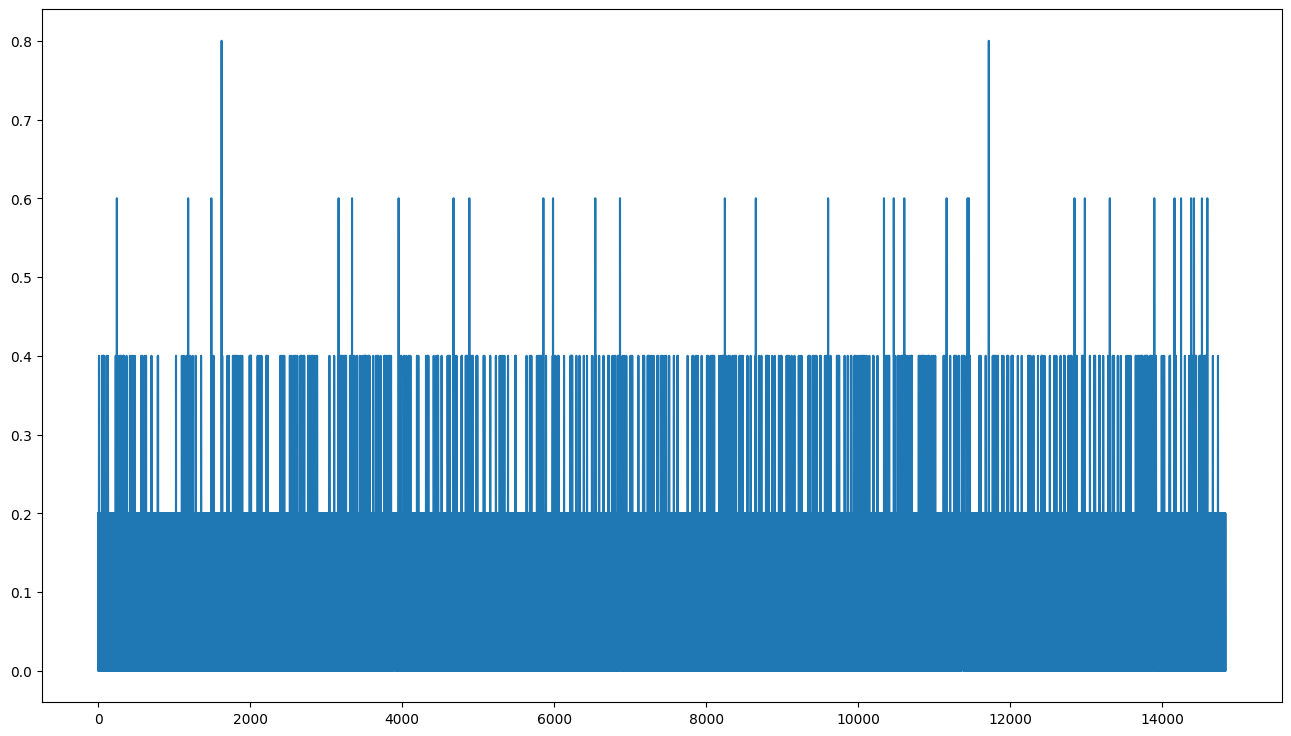

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(16, 9))

plt.plot(test_precision)

In [60]:
# Compute the maximum attainable precision@k for each user
# This is the precision when the top-k recommended items match the ground truth
max_precisions = []
for uid in range(test.shape[0]):
    # Obtain the ground truth items for the user in the test set
    ground_truth_items = test.getrow(uid).indices
    
    # Exclude users with no interactions in the test set
    # if len(ground_truth_items) == 0:
    #     continue
    
    # print(ground_truth_items)

    # Calculate the maximum attainable precision@k for the user
    max_precision = np.min([len(ground_truth_items), k]) / k
    max_precisions.append(max_precision)

# # Plot the maximum attainable precision@k for each user
# plt.figure(figsize=(10, 6))
# plt.plot(max_precisions, label='Maximum Attainable Precision@{}'.format(k))
# plt.xlabel('User ID')
# plt.ylabel('Precision@{}'.format(k))
# plt.title('Maximum Attainable Precision@{} for Each User'.format(k))
# plt.legend()
# plt.show()

42606
42606
(42606,)


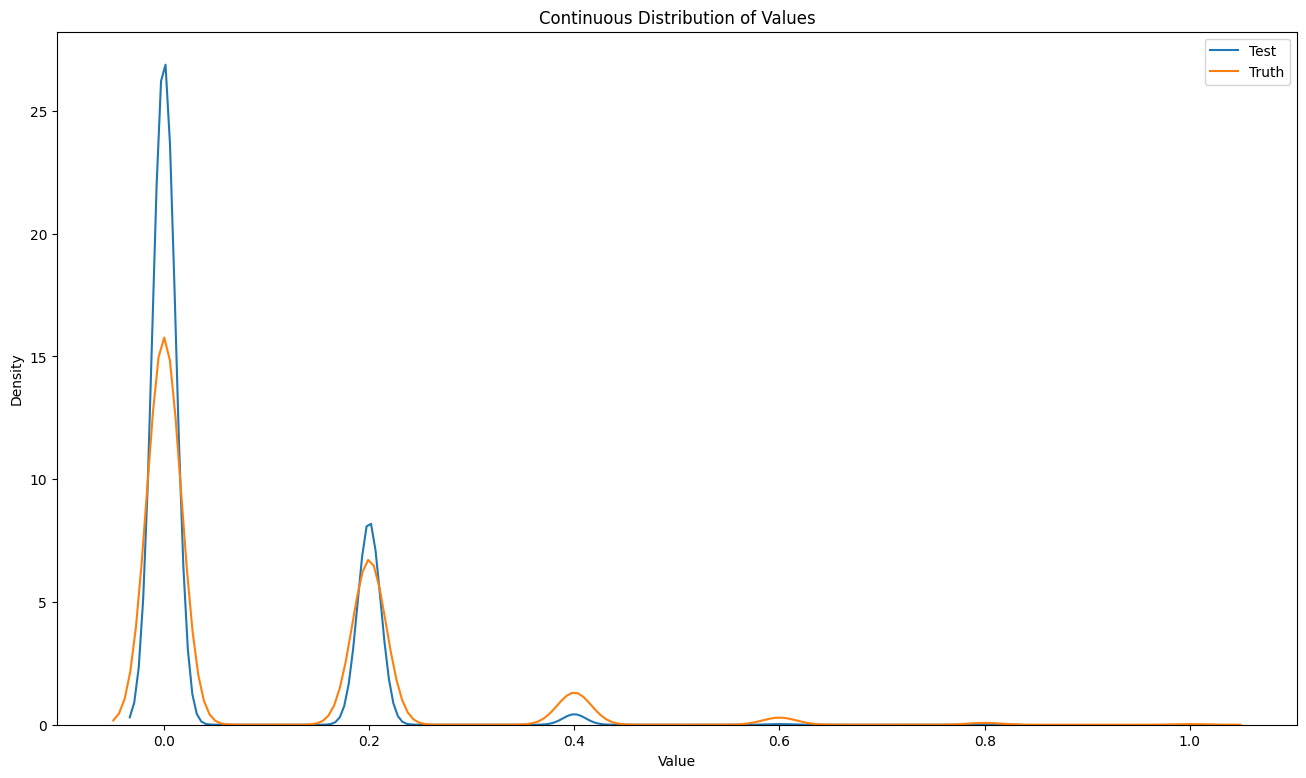

In [61]:
print(len(max_precisions))
print(test.shape[0])
print(test_precision.shape)
# Set figure size
plt.figure(figsize=(16, 9))

np.save("test_precision.npy", test_precision)
np.save("train_precision.npy", train_precision)

# Create KDE plot
sns.kdeplot(test_precision, label="Test")
sns.kdeplot(max_precisions, label="Truth")
# sns.histplot(test_precision, label="Test")
# sns.histplot(max_precisions, label="Truth")
# Add labels and title
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Continuous Distribution of Values')
plt.legend()
# Show plot
plt.show()

# Automated Hyperparameter Optimisation

In [49]:
# import optuna
# from lightfm import LightFM
# from lightfm.datasets import fetch_movielens
# from lightfm.evaluation import auc_score

# # Fetch the dataset

# def objective(trial):

#     # Best hyperparameters:  {'no_components': 45, 'learning_rate': 0.09949391010649568, 'k': 19.29548285586018, 'n': 10.515335810044794}
#     #  Other best: {'no_components': 50, 'learning_rate': 0.08062443053534539, 'k': 9.583359248210815, 'n': 5.4809279704140055}.
#     # Define the hyperparameters to be tuned
#     no_components = trial.suggest_int('no_components', 10, 50)
#     learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-1)
#     # item_alpha = trial.suggest_loguniform('item_alpha', 1e-6, 1e-1)
#     # user_alpha = trial.suggest_loguniform('user_alpha', 1e-6, 1e-1)
#     k = trial.suggest_loguniform('k', 5, 25)
#     n = trial.suggest_loguniform('n', 5, 25)
    
#     # Create the LightFM model
#     model = LightFM(
#         loss='warp',
#         no_components=no_components,
#         learning_rate=learning_rate,
#         # item_alpha=item_alpha,
#         # user_alpha=user_alpha,
#         k=k,
#         n=n
#     )
#     model.fit(train,  user_features= user_features, item_features= item_features, epochs=epoch,num_threads = num_thread, sample_weight = train_w)
    
#     # Evaluate the model
#     pak = precision_at_k(model, test,train_interactions=train, k=5,item_features=item_features, user_features=user_features, num_threads=num_thread).mean()
    
#     return pak

# # Run the optimization
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=400)

# print('Best hyperparameters: ', study.best_params)
# np.save("BestParams.npy", study.best_params)
# print('Best precision@k=5: ', study.best_value)


# Predictions

In [62]:
target_idcol = 77196041
selected_user = data[data["active_ind"]=="Semi Active"].sample(n=1)
target_idcol = selected_user["idcol"].iloc[0]
# target_idcol = 155531648
print(target_idcol)
# Rank the items based on interactions
# Assign scores to interaction types
# interaction_scores = {'DISPLAY': 0, 'CLICK': 1, 'CHECKOUT': 2}

predict_user = data[data["idcol"] == target_idcol]

predict_user.head()

# Map interaction types to scores
predict_user['interaction_score'] = predict_user['interaction'].map(interaction_scores)

# Rank items based on scores
predict_user['item_rank'] = predict_user.groupby('idcol')['interaction_score'].rank(method='max', ascending=False)

# Sort dataframe by item rank
predict_user = predict_user.sort_values(by='item_rank')

predict_user.head(-1)

true_items = predict_user['item'].tolist()
true_items = list(set(true_items))


predict_user[u_cols].head(10)
# Sit langs mekaar:
# model recommendation, user se eie actual interactions, all items popularity over entire dataset, all item popularity for user segment, all item popularity for beh_segment

446620663


KeyError: "['daily_activity_score_bin', 'activity_rate_bin', 'user_interaction_count_bin'] not in index"

In [63]:



map = dataset._user_id_mapping
index = map[target_idcol]
print(index)

scores = model.predict(index, np.arange(103), user_features=user_features, item_features=item_features)

# scores = model.predict(index, np.arange(103))
# scores = model.predict(index, np.arange(103))
# print(scores)
# print(user.iloc[index,:])
top_items = test_items.iloc[np.argsort(-scores)]
# print(scores)
# top_items.head()
# # print(item.shape)
# # print(top_items)
# known_positives = item.iloc[interactions.tocsr()[index].indices]

# top_items[0:10]
recommended_list = top_items['item'].tolist()
recommended_list = list(set(recommended_list))

recommended_list_types = top_items['item_type'].tolist()
recommended_list_types = list(set(recommended_list_types))

print(true_items)
print(recommended_list_types)

# def precision_at_k(recommended_list, actual_list, k=10):
#     # Get the intersection of the recommended list and the actual list up to k
#     intersection = set(recommended_list[:k]) & set(actual_list)
    
#     # Calculate precision@k
#     precision = len(intersection) / k
    
#     return precision

# # Calculate precision@k=10
# precision = precision_at_k(recommended_list, true_items, k=5)
# print("Precision@k=10:", precision)
data.head()
print(recommended_list.index("CTLN"))

35515
['IBAB', 'FIWL', 'CBEL', 'IBAC']
['INSURE', 'LIFESTYLE', 'INVEST', 'CONNECT', 'LEND', 'TRANSACT']
13


In [51]:
# Rank items over the entire dataset
unique_user_counts = data.groupby('item')['idcol'].nunique().reset_index(name='unique_user_count')

# Sort the items based on the count of unique users in descending order
unique_user_counts = unique_user_counts.sort_values(by='unique_user_count', ascending=False)

# Display the result
ranked_items = unique_user_counts["item"].tolist()
print(ranked_items)

['CTLN', 'IBAA', 'IBAB', 'FIHC', 'FIWL', 'CUPL', 'FILS', 'IBAC', 'CACU', 'CBPA', 'EBSH', 'CBLT', 'CBPB', 'NATR', 'CBEL', 'FICQ', 'CBVC', 'MMMC', 'NAFW', 'EBEM', 'IPRA', 'XCFL', 'NACS', 'CUPX', 'IBAM', 'MMSM', 'EBWP', 'IPTF', 'CASD', 'EBQF', 'CABC', 'IBIC', 'NASD', 'CUHS', 'CAFM', 'CSPL', 'EBET', 'CCLI', 'EBKA', 'CUSS', 'CBTULS', 'CCNC', 'CARF', 'CCAI', 'EBSB', 'EBTV', 'CBCC', 'EVCU', 'FLIS', 'CUSZ', 'CCCU', 'IBDP', 'CAFI', 'IBPP', 'IBGC', 'CASV', 'HLGG', 'EBSP', 'CARE', 'IPSG', 'EVGW', 'GASS', 'FIFS', 'EBIB', 'CCCS', 'ISBCU', 'CUSI', 'EBGA', 'CBTUD', 'SEVP', 'CUSB', 'CAFS', 'CAFU', 'CBTMT', 'CAPO', 'CBDS', 'EBUD', 'CCAN', 'HLGH', 'CALI', 'CAFB', 'EBXM', 'EVAP', 'IBDL', 'EBPD', 'EBBF', 'EBSL', 'DOAA', 'IPFD', 'KYCA', 'FHIS', 'HLGE', 'EBGM', 'GAFC', 'CANL', 'EBQB', 'WHCR', 'DOSW', 'FIWR', 'IPFN', 'IPST', 'IPMX', 'IPSD']


In [52]:
# # Rank items over the active user's segment

segment_of_interest = predict_user["segment"].iloc[0]
segment_df = data[data['segment'] == segment_of_interest]

unique_user_counts = segment_df.groupby('item')['idcol'].nunique().reset_index(name='unique_user_count')

# Sort the items based on the count of unique users in descending order
unique_user_counts = unique_user_counts.sort_values(by='unique_user_count', ascending=False)

# Display the result
ranked_items_bysegment = unique_user_counts["item"].tolist()
print(ranked_items_bysegment)


['CTLN', 'IBAA', 'IPRA', 'IBAB', 'FIHC', 'IPTF', 'FIWL', 'CUPL', 'CACU', 'CUHS', 'EBSH', 'FILS', 'CUSS', 'IBAC', 'NATR', 'CUSZ', 'CBPA', 'NAFW', 'XCFL', 'CUPX', 'CBPB', 'MMMC', 'CBVC', 'NACS', 'IBAM', 'NASD', 'FICQ', 'IBIC', 'CBEL', 'CBLT', 'CABC', 'CSPL', 'MMSM', 'CASD', 'CAFM', 'EBET', 'CCNC', 'EBEM', 'EBTV', 'CBCC', 'FLIS', 'CBTULS', 'HLGG', 'EBSB', 'EBSP', 'EVCU', 'CCCU', 'CBTMT', 'IPSG', 'IBPP', 'CASV', 'ISBCU', 'CCCS', 'CCLI', 'CARF', 'FIFS', 'IBGC', 'IBDP', 'EBIB', 'EBQF', 'EVGW', 'CBDS', 'EBGA', 'CAFS', 'CCAI', 'SEVP', 'GASS', 'EBUD', 'EBXM', 'CAFI', 'CAFU', 'CBTUD', 'CALI', 'CARE', 'CAPO', 'EVAP', 'EBWP', 'CCAN', 'IPFD', 'CAFB', 'DOAA', 'KYCA', 'IBDL', 'EBBF', 'EBQB', 'CANL', 'HLGE', 'EBPD', 'FHIS', 'FIWR', 'DOSW', 'GAFC', 'EBGM', 'IPFN', 'EBKA', 'IPST']


In [53]:
# # Rank items over the active user's beh_segment


segment_of_interest = predict_user["beh_segment"].iloc[0]
segment_df = data[data['beh_segment'] == segment_of_interest]

unique_user_counts = segment_df.groupby('item')['idcol'].nunique().reset_index(name='unique_user_count')

# Sort the items based on the count of unique users in descending order
unique_user_counts = unique_user_counts.sort_values(by='unique_user_count', ascending=False)

# Display the result
ranked_items_bybehsegment = unique_user_counts["item"].tolist()
print(ranked_items_bybehsegment)

['CTLN', 'IBAA', 'CUPL', 'FIHC', 'CACU', 'EBEM', 'EBWP', 'FICQ', 'IBAB', 'FILS', 'NATR', 'EBQF', 'FIWL', 'NAFW', 'CASD', 'EBSH', 'EBKA', 'IPRA', 'IBAC', 'CCLI', 'CAFM', 'IPTF', 'XCFL', 'NASD', 'CUHS', 'CBVC', 'CBPA', 'EBSB', 'EBET', 'CARF', 'CCAI', 'CSPL', 'MMMC', 'CBPB', 'NACS', 'CUPX', 'CBLT', 'CABC', 'CCNC', 'CBEL', 'CCCU', 'MMSM', 'CUSS', 'EBTV', 'IBAM', 'CAFI', 'FLIS', 'CARE', 'IBIC', 'IBGC', 'IBDP', 'IBPP', 'CUSZ', 'CBTULS', 'CCCS', 'EBIB', 'CUSI', 'EVGW', 'CAFU', 'CBCC', 'GASS', 'CAFS', 'EBGA', 'HLGG', 'CASV', 'CUSB', 'HLGH', 'ISBCU', 'FIFS', 'EVCU', 'SEVP', 'EBSP', 'IPSG', 'EBUD', 'CALI', 'CBTMT', 'CAFB', 'EBXM', 'CBDS', 'IBDL', 'EBPD', 'EBSL', 'CBTUD', 'CCAN', 'EVAP', 'CAPO', 'DOAA', 'EBBF', 'FHIS', 'HLGE', 'EBGM', 'IPFD', 'KYCA', 'WHCR', 'GAFC', 'EBQB', 'CANL', 'FIWR', 'DOSW', 'IPMX', 'IPFN', 'IPSD', 'IPST']


In [64]:
# Show the true items for the 2 next most similar users
# First, lets find the two most similar users:
def similar_users(user_id, model, N=10, norm = True):
    user_bias ,user_representations = model.get_user_representations(features= user_features)
    # user_bias ,user_representations = model.get_user_representations()

    # Cosine similarity
    scores = user_representations.dot(user_representations[user_id, :])
    item_norms = np.linalg.norm(user_representations, axis=1)
    
    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] / item_norms[user_id]), 
                    key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]), 
                    key=lambda x: -x[1])
    return similar
    
# map = dataset._user_id_mapping
# index = map[77196041]
similar_item_list = similar_users(index,model, N = 3, norm=True)
display(similar_item_list)
similar_idx = [x[0] for x in similar_item_list]
filtered_data = user.loc[similar_idx, :]
filtered_data.head(20)

two_users = filtered_data["idcol"].tolist()[1:]
print(two_users)

next_two_users_items = []
for id in two_users:
    predict_user = data[data["idcol"] == id]
    true = predict_user['item'].tolist()
    true = list(set(true))
    next_two_users_items.append(true)


print(next_two_users_items[1])

# Function to look up item_type by item_id
def get_item_type(item):
    # Use loc to find the row where item_id matches and get the item_type
    item_type = test_items.loc[test_items['item'] == item, 'item_type']
    # Return the item_type if found, otherwise return None
    return item_type.iloc[0] if not item_type.empty else None

itm_tps = []
for x in recommended_list:
    itm_tps.append(get_item_type(x))

true_item_types = []
for x in true_items:
    true_item_types.append(get_item_type(x))

ranked_tps = []
for x in ranked_items:
    ranked_tps.append(get_item_type(x))

rank_seg_tps = []
for x in ranked_items_bysegment:
    rank_seg_tps.append(get_item_type(x))

rank_bseg_tps = []
for x in ranked_items_bybehsegment:
    rank_bseg_tps.append(get_item_type(x))

[(35515, 1.0), (26808, 0.9332031), (25115, 0.91790706)]

[200005707, 168281826]
['IBAB', 'IBAC']


In [55]:
# Combine all those into a single dataframe so I can see them side by side
num_item = len(true_items)
max_length = 30
# print(num_item)


recdata = {
    'True Items': true_items + [None] * (max_length - num_item),
    'typs': true_item_types + [None] * (max_length - len(true_item_types)),
    'User2' : next_two_users_items[0] + [None] * (max_length - len(next_two_users_items[0])),
    'User3' : next_two_users_items[1] + [None] * (max_length - len(next_two_users_items[1])),
    'Recommended Items': recommended_list[:max_length],
    "Rec itm types": itm_tps[:max_length],
    'Most Popular Tot': ranked_items[:max_length],
    "pop types": ranked_tps[:max_length],
    'Most Popular Seg': ranked_items_bysegment[:max_length],
    "popseg types": rank_seg_tps[:max_length],
    'Most Popular BSeg': ranked_items_bybehsegment[:max_length],
    "popbseg types": rank_bseg_tps[:max_length],
}

# Create DataFrame from dictionary
df = pd.DataFrame(recdata)

def listwise_precision_at_k(recommended_list, actual_list, k=20):
    # Get the intersection of the recommended list and the actual list up to k
    intersection = set(recommended_list[:k]) & set(actual_list)
    
    # Calculate precision@k
    precision = len(intersection) / k
    
    return precision

print(listwise_precision_at_k(recommended_list, true_items))

df.head(-1)


# True items for next 2 most similar users
# Recommend items' types


NameError: name 'true_item_types' is not defined

## Similar Item Calculation using cosine similarity

In [ ]:
def similar_items(item_id, model, N=10, norm = True):
    item_bias ,item_representations = model.get_item_representations(features=item_features)

    # Cosine similarity
    scores = item_representations.dot(item_representations[item_id, :])
    item_norms = np.linalg.norm(item_representations, axis=1)

    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]/ item_norms[item_id] ), key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] ), key=lambda x: -x[1])
    return similar


value_to_find = 'EBSH'
value_to_compare = "SEVP"
index = test_items['item'].eq(value_to_find).idxmax()
print(index)
similar_item_list = similar_items(index, model, N=103)

simscores = [x[1] for x in similar_item_list]


similar_idx = [x[0] for x in similar_item_list ]
siitms = test_items.iloc[similar_idx]# Can also add the other

siitms["scores"] = simscores

siitms.head(104)


scores_column_name = "scores"  # Replace this with the actual column name

# Filter the DataFrame based on the condition value_to_compare
filtered_items = siitms[siitms["item"] == value_to_compare]

# Check if any items match the condition
if not filtered_items.empty:
    # Extract the score from the first matching item
    compare_score = filtered_items.iloc[0][scores_column_name]
    print("Comparison score:", compare_score)
else:
    print("No items matching the condition:", value_to_compare)

# print(compare_score)

In [ ]:
def similar_items(item_id, model, N=10, norm = True):
    item_bias ,item_representations = model.get_item_representations(features=item_features)

    # Cosine similarity
    scores = item_representations.dot(item_representations[item_id, :])
    item_norms = np.linalg.norm(item_representations, axis=1)

    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]/ item_norms[item_id] ), key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] ), key=lambda x: -x[1])
    return similar


value_to_find = 'CTLN'
index = test_items['item'].eq(value_to_find).idxmax()
print(index)
similar_item_list = similar_items(index, model, N=10)

simscores = [x[1] for x in similar_item_list]


similar_idx = [x[0] for x in similar_item_list ]
siitms = test_items.iloc[similar_idx]# Can also add the other

siitms["scores"] = simscores

siitms.head(104)


In [ ]:
nan_counts = siitms.isna().sum()
nan_counts

## Similar User Calculation

In [69]:
def similar_users(user_id, model, N=10, norm = True):
    user_bias ,user_representations = model.get_user_representations(features= user_features)

    # Cosine similarity
    scores = user_representations.dot(user_representations[user_id, :])
    item_norms = np.linalg.norm(user_representations, axis=1)
    
    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] / item_norms[user_id]), 
                    key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]), 
                    key=lambda x: -x[1])
    return similar
    
# map = dataset._user_id_mapping
# index = map[77196041]
similar_item_list = similar_users(index,model, N = 6)
print(similar_item_list)
simscores = [x[1] for x in similar_item_list]
similar_idx = [x[0] for x in similar_item_list]
filtered_data = user.loc[similar_idx, :]
filtered_data["scores"] = simscores


filtered_data = filtered_data.drop(columns = ["most_interacted", "most_interacted_item"])
filtered_data.head(20)

[(35515, 1.0), (26808, 0.9332031), (25115, 0.91790706), (29669, 0.9091652), (36317, 0.8946705), (37978, 0.8928452)]


,idcol,segment,beh_segment,active_ind,daily_activity_score_bin,activity_rate_bin,user_interaction_count_bin,most_frequent_day,scores
35515,446620663,segment1,B18,Semi Active,"(1.833, 2.0]","(0.0455, 0.0568]","(9.0, 11.0]",Monday,1.000000
26808,200005707,segment1,B18,Active,"(1.667, 1.833]","(0.0341, 0.0455]","(6.0, 7.0]",Monday,0.933203
25115,168281826,segment1,B08,Semi Active,"(2.833, 3.0]","(0.0104, 0.0227]","(5.0, 6.0]",Thursday,0.917907
29669,259775928,segment1,B18,Active,"(1.5, 1.667]","(0.0795, 0.557]","(11.0, 16.0]",Wednesday,0.909165
36317,483508836,segment1,B01,Active,"(1.25, 1.5]","(0.0104, 0.0227]","(2.0, 3.0]",Monday,0.894670
37978,23050559118,segment1,B08,Semi Active,"(1.25, 1.5]","(0.0227, 0.0341]","(3.0, 4.0]",Thursday,0.892845


In [ ]:
# print(u_cols)


# i = 0
# lists = []
# for index, row in filtered_data.iterrows():
#     print(row)
#     break
#     userlst = []
#     pos_idxs = row[row == 1].index.tolist()
#     userlst.append(filtered_data.iloc[i,0])
#     userlst += pos_idxs
    
#     i+=1
#     lists.append(userlst)


# new_df = pd.DataFrame(data = lists, columns = u_cols)
# new_df.head(-1)



## Cold Start Problem

In [ ]:
# import random

# from scipy import sparse

# def format_newuser_input(user_feature_map, user_feature_list):
#   num_features = len(user_feature_list)
#   normalised_val = 1.0 
#   target_indices = []
#   for feature in user_feature_list:
#     try:
#         target_indices.append(user_feature_map[feature])
#     except KeyError:
#         print("new user feature encountered '{}'".format(feature))
#         pass

#   new_user_features = np.zeros(len(user_feature_map.keys()))
#   for i in target_indices:
#     new_user_features[i] = normalised_val
#   new_user_features = sparse.csr_matrix(new_user_features)
#   return(new_user_features)

# user_id_map, user_feature_map, item_id_map, item_feature_map = dataset.mapping()
# user_feature_list = ["segment4", "B01", "Cold Start"]

# new_user_features = format_newuser_input(user_feature_map, u_cols)
# scores = model.predict(0, np.arange(104), user_features=new_user_features)

# top_items = item.iloc[np.argsort(-scores)]

# top_items.head()

# new_user = pd.DataFrame(np.zeros(len(user_features_col))).T
# new_user.columns = user_features_col
# # print(new_user)

# new_user.head()


# new_user_id = 86000
# new_user['segment4'] = 1
# new_user['B50'] = 1
# new_user['Cold Start'] = 1

# new_user = csr_matrix(new_user)
# scores = model.predict(user_ids = 0,item_ids = np.arange(interactions.shape[1]), user_features=new_user)
# top_items_new_user = item.iloc[np.argsort(-scores)]
# top_items_new_user[0:10]
user.head()
user.dtypes

In [ ]:
# Use our isolated user to check our algorithm:
# We predict items for this user, then check the precision at k=5.

idcol = 99999999999
segment = "segment4"
beh_segment = "B07"
active_ind = "Cold Start"

column_names = u_cols
# Populate the new DataFrame with relevant information from the original DataFrame
new_user_data = {
    'idcol': idcol,
    'segment': segment,
    'beh_segment': beh_segment,
    'active_ind': active_ind,
    'most_interacted': np.nan,
    'most_interacted_item': np.nan,
    'daily_activity_score_bin': np.nan,
    'activity_rate_bin': np.nan,
    'user_interaction_count_bin': np.nan,
    'most_frequent_day': np.nan
}

print(new_user_data)

new_user = pd.DataFrame(new_user_data, index=[0])

# Function to fill NaN values in the new row
# def fill_na_with_mode_or_mean(data, cold_start_user):
#     filled_row = cold_start_user.copy()
    
#     for column in data.columns:
#         if cold_start_user[column].isna().any():
#             if data[column].dtype == 'object':  # Categorical data
#                 mode_value = data[column].mode()[0]
#                 filled_row[column].fillna(mode_value, inplace=True)
#             else:  # Numerical data
#                 mean_value = data[column].mean()
#                 filled_row[column].fillna(mean_value, inplace=True)
    
#     return filled_row

def fill_na_with_mode_or_mean(data, cold_start_user):
    filled_row = cold_start_user.copy()
    # data = data.astype(str)
    for column in data.columns:
        if cold_start_user[column].isna().any():
            if pd.api.types.is_object_dtype(data[column]):  # Categorical data
                mode_value = data[column].mode()[0]
                filled_row[column].fillna(mode_value, inplace=True)
            elif pd.api.types.is_numeric_dtype(data[column]):  # Numeric data
                mean_value = data[column].mean()
                filled_row[column].fillna(mean_value, inplace=True)
            elif pd.api.types.is_categorical_dtype(data[column]):  # Check if dtype is categorical
                mode_value = data[column].mode()[0]
                filled_row[column].fillna(mode_value, inplace=True)
    
    return filled_row

new_user_completed = fill_na_with_mode_or_mean(user, new_user)
# new_user_sparse = pd.get_dummies(new_user_completed,dtype = int, prefix="", prefix_sep="")
# # new_user_sparse.head()
new_user_completed.head()
# print(len(user_features_col))

In [ ]:
# (0.999, 1.25]
# (1.25, 1.5]
# (1.5, 1.667]
# (1.667, 1.833]
# (1.833, 2.0]
# (2.0, 2.25]
# (2.25, 2.5]
# (2.5, 2.833]
# (2.833, 3.0]
# (3.0, 3.5]
# (3.5, 65.0]

# (0.0104, 0.0227]
# (0.0227, 0.0341]
# (0.0341, 0.0455]
# (0.0455, 0.0568]
# (0.0568, 0.0795]
# (0.0795, 0.557]

# (0.999, 2.0]
# (2.0, 3.0]
# (3.0, 4.0]
# (4.0, 5.0]
# (5.0, 6.0]
# (6.0, 7.0]
# (7.0, 9.0]
# (9.0, 11.0]
# (11.0, 16.0]
# (16.0, 204.0]
# print(user_features_col)
# user_train.head()
# print(
# user["activity_rate_bin"].unique())
user.head()
# print(type(user["daily_activity_score_bin"].unique()[0]))
# print(type(new_user_completed["daily_activity_score_bin"].iloc[0]))

# print(user["daily_activity_score_bin"].unique()[0])
# print(new_user_completed["daily_activity_score_bin"].iloc[0])

# print(new_user_completed["daily_activity_score_bin"].iloc[0] == user["daily_activity_score_bin"].astype(str).unique()[0])

# user_bins_str = [str(interval) for interval in user["daily_activity_score_bin"].unique()]
# new_user_completed_bins_str = [str(interval) for interval in new_user_completed["daily_activity_score_bin"].unique()]

# # Compare the intervals as strings
# print(new_user_completed_bins_str[0] == user_bins_str[0])

In [ ]:
new_user_wide = pd.DataFrame(np.zeros(len(user_features_col))).T
new_user_wide.columns = user_features_col
new_user_wide.reset_index(drop=True, inplace=True)
# print(new_user_wide)

# Populate segment columns
segments = ['segment1', 'segment2', 'segment3', 'segment4']
for segment in segments:
    new_user_wide[segment] = (new_user_completed['segment'] == segment).astype(int)

# Populate behavior segment columns
beh_segments = ['B{:02d}'.format(i) for i in range(1, 51)]
beh_segments.remove("B43")
beh_segments.remove("B45")
for beh_segment in beh_segments:
    new_user_wide[beh_segment] = (new_user_completed['beh_segment'] == beh_segment).astype(int)

# Convert index values of new_user_wide to strings
new_user_wide.index = new_user_wide.index.astype(str)


# Populate other columns
bins1 = [str(interval) for interval in user["daily_activity_score_bin"].unique()]
for bin in bins1:
    # print(new_user_completed[column])
    # print(new_user_wide.index)
    # break
    new_user_wide[bin] = int((bin == [str(interval) for interval in new_user_completed["daily_activity_score_bin"].unique()][0]))

# Populate other columns
bins2 = [str(interval) for interval in user["activity_rate_bin"].unique()]
for bin in bins2:
    # print(new_user_completed[column])
    # print(new_user_wide.index)
    # break
    new_user_wide[bin] = int((bin == [str(interval) for interval in new_user_completed["activity_rate_bin"].unique()][0]))
# Populate other columns
bins3 = [str(interval) for interval in user["user_interaction_count_bin"].unique()]
for bin in bins3:
    # print(new_user_completed[column])
    # print(new_user_wide.index)
    # break
    new_user_wide[bin] = int((bin == [str(interval) for interval in new_user_completed["user_interaction_count_bin"].unique()][0]))

days = ['Monday', "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
for day in days:
    print(new_user_completed['most_frequent_day'] == day)
    new_user_wide[day] = int(new_user_completed['most_frequent_day'] == day)

# Print the populated sparse DataFrame
# print(new_user_wide)
new_user_wide.head()


In [ ]:
for c in new_user_wide.columns:
    print (c)

In [ ]:
new_user_csr = csr_matrix(new_user_wide)
# new_user = csr_matrix(new_user)
print(new_user_csr.shape)
scores = model.predict(user_ids = 0,item_ids = np.arange(interactions.shape[1]), user_features=new_user_csr, item_features=item_features)
top_items_new_user = test_items.iloc[np.argsort(scores)]
top_items_new_user[0:20]


In [ ]:
print(user_features.shape)


new_user_completed_dum = pd.get_dummies(new_user_completed,dtype = int, prefix="", prefix_sep="")
# user_features_col = new_user_completed_dum.drop(columns =['idcol']).columns.values
cold_user_feat = new_user_completed_dum.drop(columns =['idcol']).to_dict(orient='records')

new_user_completed_dum = new_user_completed_dum.sort_values(by='idcol', ascending=True)
new_user_wide["idcol"] = idcol
print(user_feat)

In [ ]:
# A = new_user_wide.columns
# B = user_train.columns
# # Convert lists to sets
# set_A = set(A)
# set_B = set(B)

# # Values in list A that are not in list B
# result = list(set_A - set_B)

# print(user_feat)  # Output: [1, 2]

# new_user_wide.head()

In [ ]:
users=[x for x in user_train['idcol']] + [idcol]

all_users = user_feat + cold_user_feat

# dataset.fit(users=users, items=items, user_features=user_features_col)
dataset.fit(users=users, items=items, user_features=user_features_col, item_features=item_features_col)

cold_user_features = dataset.build_user_features(((x,y) for x,y in zip(new_user_wide['idcol'],all_users)), normalize=False)


In [ ]:
def similar_users(user_id, model, N=10, norm = True):
    user_bias ,user_representations = model.get_user_representations(features= cold_user_features)

    # Cosine similarity
    scores = user_representations.dot(user_representations[user_id, :])
    item_norms = np.linalg.norm(user_representations, axis=1)
    
    if norm == True:
        scores /= item_norms
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best] / item_norms[user_id]), 
                    key=lambda x: -x[1])
    else:
        best = np.argpartition(scores, -N)[-N:]
        similar = sorted(zip(best, scores[best]), 
                    key=lambda x: -x[1])
    return similar
    
map = dataset._user_id_mapping
index = map[99999999999]
similar_item_list = similar_users(index,model, N = 3)
print(similar_item_list)
similar_idx = [x[0] for x in similar_item_list]
filtered_data = user.loc[similar_idx, :]
filtered_data.head(20)



# PPTX
## Activity Scpre

In [ ]:
import pandas as pd
# Add user daily activity score:
# On days that they are active, how many interactions do they make?
# Convert int_date to datetime

data = pd.read_csv("./fnb_datav2.csv")
data['int_date'] = pd.to_datetime(data['int_date'], format='%d%b%Y')

# Group by idcol to calculate total interactions and unique active days
user_interactions = data.groupby('idcol').size().reset_index(name='total_interactions')
active_days = data.groupby('idcol')['int_date'].nunique().reset_index(name='unique_active_days')

# Merge the results to calculate daily_activity_score
user_activity = pd.merge(user_interactions, active_days, on='idcol')
user_activity['daily_activity_score'] = user_activity['total_interactions'] / user_activity['unique_active_days']

# Merge the daily_activity_score back to the original DataFrame
data2 = pd.merge(data, user_activity[['idcol', 'daily_activity_score']], on='idcol', how='left')

data2.head(10)

# Calculate the mean daily activity score per segment
segment_activity_rate = data2.groupby('segment')['daily_activity_score'].mean().reset_index()

# Plot the activity score per segment
# plt.figure(figsize=(10, 6))
# plt.bar(segment_activity_rate['segment'], segment_activity_rate['daily_activity_score'])
# plt.xlabel('Segment')
# plt.ylabel('Average Daily Activity Score')
# plt.title('Average Daily Activity Score per Segment')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
from pptx.enum.chart import XL_CHART_TYPE
from pptx.chart.data import CategoryChartData

# Create a new chart data object
chart_data_global = CategoryChartData()
chart_data_global.categories = segment_activity_rate.values[:,0]

print(segment_activity_rate.values[:,0])

# Add the series
chart_data_global.add_series('Normalized Frequency', segment_activity_rate.values[:,1])

# Open the existing PowerPoint presentation
prs = Presentation("Presentation6.pptx")

# Add a new slide for the bar chart
slide_layout = prs.slide_layouts[5]  # Using the "Title and Content" layout
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
title.text = "Daily Activity Score"

# Add the chart to the slide
x, y, cx, cy = Inches(1), Inches(2), Inches(8), Inches(4.5)
chart = slide.shapes.add_chart(
    XL_CHART_TYPE.COLUMN_CLUSTERED, x, y, cx, cy, chart_data_global
).chart

# Set chart title
chart.has_title = True
chart.chart_title.text_frame.text = "Daily Activity Score per Segment"

# Save the presentation
prs.save('Presentation6.pptx')

## Activity Rate

In [ ]:
# Convert int_date to datetime
data['int_date'] = pd.to_datetime(data['int_date'])

# Calculate the total number of unique days in the dataset
total_days = data["int_date"].nunique()

# Calculate the number of unique days each user had interactions
user_unique_days = data.groupby('idcol')['int_date'].nunique()

# Calculate the activity rate
activity_rate = user_unique_days / total_days

# Merge the activity_rate back into the original dataframe
data3 = data.merge(activity_rate.rename('activity_rate'), on='idcol')

data3.head(20)
# Calculate the mean daily activity score per segment
segment_activity_rate_seg = data3.groupby('segment')['activity_rate'].mean().reset_index()

# # Plot the activity score per segment
# plt.figure(figsize=(10, 6))
# plt.bar(segment_activity_rate['segment'], segment_activity_rate['activity_rate'])
# plt.xlabel('Segment')
# plt.ylabel('Average Daily Activity rate')
# plt.title('Average Daily Activity rate per Segment')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
from pptx.enum.chart import XL_CHART_TYPE
from pptx.chart.data import CategoryChartData

# Create a new chart data object
chart_data_global = CategoryChartData()
chart_data_global.categories = segment_activity_rate_seg.values[:,0]

print(segment_activity_rate_seg.values[:,0])

# Add the series
chart_data_global.add_series('Nananas', segment_activity_rate_seg.values[:,1])

# Open the existing PowerPoint presentation
prs = Presentation("Presentation6.pptx")

# Add a new slide for the bar chart
slide_layout = prs.slide_layouts[5]  # Using the "Title and Content" layout
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
title.text = "Souskluie"

# Add the chart to the slide
x, y, cx, cy = Inches(1), Inches(2), Inches(8), Inches(4.5)
chart = slide.shapes.add_chart(
    XL_CHART_TYPE.COLUMN_CLUSTERED, x, y, cx, cy, chart_data_global
).chart

# Set chart title
chart.has_title = True
chart.chart_title.text_frame.text = "Woestersous"

# Save the presentation
prs.save('Presentation6.pptx')

## Training Results

In [ ]:
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
from pptx.enum.chart import XL_CHART_TYPE
from pptx.chart.data import CategoryChartData

# Create a new chart data object
chart_data_global = CategoryChartData()
chart_data_global.categories = segment_activity_rate_seg.values[:,0]

print(segment_activity_rate_seg.values[:,0])

# Add the series
chart_data_global.add_series('Nananas', segment_activity_rate_seg.values[:,1])

# Open the existing PowerPoint presentation
prs = Presentation("Presentation6.pptx")

# Add a new slide for the bar chart
slide_layout = prs.slide_layouts[5]  # Using the "Title and Content" layout
slide = prs.slides.add_slide(slide_layout)
title = slide.shapes.title
title.text = "Souskluie"

# Add the chart to the slide
x, y, cx, cy = Inches(1), Inches(2), Inches(8), Inches(4.5)
chart = slide.shapes.add_chart(
    XL_CHART_TYPE.COLUMN_CLUSTERED, x, y, cx, cy, chart_data_global
).chart

# Set chart title
chart.has_title = True
chart.chart_title.text_frame.text = "Woestersous"

# Save the presentation
prs.save('Presentation6.pptx')